# Forward-backward splitting for time-varying graphical lasso
This notebook shows how to minimise the time-varying graphical lasso with element-wise penalty norms across time-points.

First of all, as always, let's create a bunch of data.
For this task, we generate eah variable to change according to a certain behaviour which can be described as evolution via tigonometric functions, such as `sin` and `cos`.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import squareform
from regain import datasets, utils

from sklearn.datasets import load_iris
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ShuffleSplit

from skopt.searchcv import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [2]:
# np.random.seed(7)

# fs = 10e3
# N = 100
# amp = 2*np.sqrt(2)
# freq = 1.0
# noise_power = 0.001 * fs / 2
# time = np.arange(N) / fs
# z = amp*np.sin(2*np.pi*freq*time)
# z += np.random.normal(scale=np.sqrt(noise_power), size=time.shape)
# plt.plot(z);

In [3]:
# T = 4

# x = np.tile(np.linspace(0, T-1, T), (n_interactions, 1))
# zz = amp * signal.square(2 * np.pi * freq * x + phase, duty=.5)
# plt.plot(x.T, zz.T);

Generate the data starting from the inverse covariance matrices.

In [4]:
from regain.datasets import *

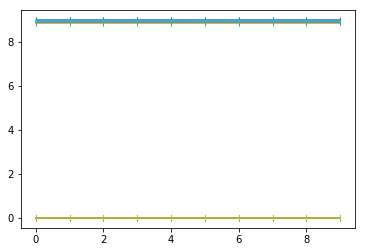

In [755]:
def make_sin(n_dim_obs, n_dim_lat, T, shape='smooth', closeness=1,
             normalize=False, **kwargs):
    upper_idx = np.triu_indices(n_dim_obs, 1)
    n_interactions = len(upper_idx[0])
    x = np.tile(np.linspace(0, (T-1.) / closeness, T), (n_interactions, 1))
    phase = np.random.rand(n_interactions, 1)
    freq = np.random.rand(n_interactions, 1) - .250
    A = (np.random.rand(n_interactions, 1) + 2) / 2.

    if shape == 'smooth':
        y = A * np.sin(2. * np.pi * freq * x + phase)
    else:
        A -= 10
        y = A * signal.square(2 * np.pi * freq * x + phase, duty=.5)

    # threshold
    y = np.maximum(y, 0)
#     print y

    Y = np.array([squareform(y[:, j]) + np.diag(np.sum(squareform(y[:, j]), axis=1))
                  for j in range(y.shape[1])])

    Y = np.array([y - np.diag(np.diag(y)) for y in Y])
    for y in Y:
        np.fill_diagonal(y, y.sum(axis=1)+0.5)
        
    if normalize:
        map(normalize_matrix, Y)  # in place
        
    # XXX
    if shape == 'square':
        Y = np.array([Y[4]] * T)
    
    assert positive_definite(Y), Y
    

    return Y, Y, np.zeros_like(Y)

data = {}
np.random.seed(7)
# square
n_samples = 200
n_dim_obs = 200
T = 10
data['square'] = datasets.make_dataset(n_samples=n_samples, n_dim_obs=n_dim_obs, n_dim_lat=0, T=T,
                             time_on_axis='last',
                             mode=make_sin, shape='square', closeness=5, normalize=0)

# smooth
np.random.seed(10)
n_samples = 200
n_dim_obs = 200
T = 10

data['smooth'] = datasets.make_dataset(n_samples=n_samples, n_dim_obs=n_dim_obs, n_dim_lat=0, T=T,
                             time_on_axis='last',
                             mode=make_sin, shape='smooth', closeness=6, normalize=0)

# plt.plot(np.array([squareform(y, checks=None)[:10] for y in data['smooth'].thetas]), '-|');
plt.step(np.array([squareform(y, checks=None)[10:20] for y in data['square'].thetas]), '-|');

In [706]:
(data['square'].thetas == 0).sum() / float(data['square'].thetas.size)

0.66328

In [7]:
# np.random.seed(7)

# # square
# n_samples = 100
# n_dim_obs = 20
# T = 10

# data = {}
# data['square'] = datasets.make_dataset(n_samples=n_samples, n_dim_obs=n_dim_obs, n_dim_lat=0, T=T,
#                              time_on_axis='last',
#                              mode='sin', shape='square', closeness=2.4, normalize=1)

# # smooth
# n_samples = 100
# n_dim_obs = 20
# T = 10

# data['smooth'] = datasets.make_dataset(n_samples=n_samples, n_dim_obs=n_dim_obs, n_dim_lat=0, T=T,
#                              time_on_axis='last',
#                              mode='sin', shape='smooth', closeness=2.4, normalize=1)

# plt.plot(np.array([squareform(y, checks=None)[:10] for y in data['smooth'].thetas]), '-|');
# # plt.savefig("/home/fede/Dropbox/Latent variables networks/forward backward time varying graphical lasso/smooth_signal.pdf")

## Performance analysis

In [8]:
# tglfb = tglfb.set_params(time_norm=1, alpha=np.array(alphas_)[:,None,None], beta=35).fit(X)

In [9]:
import pandas as pd
from functools import partial
from regain import prox; reload(prox)
from regain import utils; reload(utils)
from regain import update_rules; reload(update_rules);
from regain.covariance import time_graph_lasso_ as tgl_admm; reload(tgl_admm)
from regain.forward_backward import time_graph_lasso_; reload(time_graph_lasso_)

from sklearn.covariance import GraphLasso, GraphLassoCV
import sys; sys.path.append("/home/fede/src/TVGL")
import inferGraphL1; reload(inferGraphL1)
import inferGraphL2; reload(inferGraphL2)
import inferGraphLaplacian; reload(inferGraphLaplacian)
import TVGL; reload(TVGL)

# use:
# beta = 2.1, norm = 1
# beta = 5.05, norm = 2
# prepare dataframe for results

methods = ['TGL-FBS ($\ell_{12}$)', 'TGL-FBS ($\ell_1$)',
           'TGL-ADMM ($\ell_2^2$)', 'TGL-ADMM ($\ell_1$)',
#            'GL', 'TVGL ($\ell_2^2$)', 'TVGL ($\ell_1$)'
          ]

scores = sorted(['iter', 'accuracy',  'average_precision',  'balanced_accuracy','f1','false_omission_rate','fdr',
                 'fn',  'fp',  'precision',  'prevalence',  'recall',  'specificity',  'tn',  'tp', 'mse',
                'time'])
evolution = sorted(['square', 'smooth'])

rows = methods
cols = pd.MultiIndex.from_product([evolution, scores], names=('evolution', 'score'))
# rows = pd.MultiIndex.from_product([methods, n_times], names=('method','time'))

dff = pd.DataFrame(columns=cols, index=rows)
idx = pd.IndexSlice

ss = ['f1', 'accuracy', 'average_precision', 'mse', 'iter', 'time']

In [10]:
# def run_performance(beta_l1=1, beta_l2=1, alpha_l1=1, alpha_l2=1, evolution='square'):
# evolution = 'square'
evolution = 'square'
max_iter = 5000000

In [11]:
from sklearn.covariance import empirical_covariance
reload(utils)
emp_cov = [empirical_covariance(x, assume_centered=False) for x in data[evolution].data.transpose(2,0,1)]
alphas = np.array([utils.alpha_heuristic(e, n_samples) for e in emp_cov])[:, None, None]

In [12]:
import time
from itertools import product
# for evolution, max_iter in product(['square', 'smooth'], 
# [50, 100]):
X = data[evolution].data

error_function = partial(utils.structure_error,
                         data[evolution].thetas,
                         no_diagonal=0, thresholding=1, eps=1e-3)

if evolution == 'smooth':
    alpha = .01
    beta = 20
    eps = 0.7
    delta = 0.7
    
else:
    alpha = .2
    beta = 50
    eps = 0.7
    delta = 0.9

Find the minimum with the function below ... first generate the plot!
And then, the minimum should be in a `mm` variable.

In [ ]:
tglfb = time_graph_lasso_.TimeGraphLassoForwardBackward(
    verbose=0, gamma=1, alpha=alpha, beta=beta,
    return_n_linesearch=True, return_history=True,
    delta=delta, choose='lamda',
    lamda=1, tol=1e-4, eps=eps, debug=1, vareps=0,
    time_norm=1, max_iter=5000000, time_on_axis='last',
    stop_at=mm, stop_when=1e-2)

tic = time.time()
tglfb.fit(X)
toc = time.time()
res = error_function(tglfb.precision_)

res['time'] = toc - tic
res['iter'] = "%d (%d)" % (tglfb.n_iter_, tglfb.n_linesearch_)
res['mse'] = utils.error_norm(data[evolution].thetas, 
                              tglfb.precision_,
                              upper_triangular=True)
dff.loc['TGL-FBS lamda ($\ell_1$)', idx[evolution, :]] = [
    res[x] for x in scores]

In [ ]:
tglfb2 = time_graph_lasso_.TimeGraphLassoForwardBackward(
    verbose=0, gamma=1, alpha=alpha, beta=beta,
    return_n_linesearch=True, return_history=True,
    delta=delta, choose='both',
    lamda=1, tol=1e-4, eps=eps, debug=1, vareps=0,
    time_norm=1, max_iter=max_iter, time_on_axis='last',
    stop_at=mm, stop_when=1e-2)

tic = time.time()
tglfb2.fit(X)
toc = time.time()
res = error_function(tglfb2.precision_)

res['time'] = toc - tic
res['iter'] = "%d (%d)" % (tglfb2.n_iter_, tglfb2.n_linesearch_)
res['mse'] = utils.error_norm(data[evolution].thetas, 
                              tglfb2.precision_,
                              upper_triangular=True)
dff.loc['TGL-FBS both ($\ell_1$)', idx[evolution, :]] = [
    res[x] for x in scores]


tglfb3 = time_graph_lasso_.TimeGraphLassoForwardBackward(
    verbose=0, gamma=1, alpha=alpha, beta=beta,
    return_n_linesearch=True, return_history=True,
    delta=delta, choose='gamma',
    lamda=1, tol=1e-4, eps=eps, debug=1, vareps=0,
    time_norm=1, max_iter=max_iter, time_on_axis='last',
    stop_at=mm, stop_when=1e-2)

tic = time.time()
tglfb3.fit(X)
toc = time.time()
res = error_function(tglfb3.precision_)

res['time'] = toc - tic
res['iter'] = "%d (%d)" % (tglfb3.n_iter_, tglfb3.n_linesearch_)
res['mse'] = utils.error_norm(data[evolution].thetas, 
                              tglfb3.precision_,
                              upper_triangular=True)
dff.loc['TGL-FBS gamma ($\ell_1$)', idx[evolution, :]] = [
    res[x] for x in scores]

In [ ]:
tglfb_admm_square = tgl_admm.TimeGraphLasso(
    verbose=0, alpha=alpha, beta=beta, tol=-1e-5, rtol=1e-5, return_history=True,
    psi='l1', max_iter=max_iter, time_on_axis='last',
    stop_at=mm, stop_when=1e-2)
tic = time.time()
tglfb_admm_square.fit(X)
toc = time.time()

res = error_function(tglfb_admm_square.precision_)
res['time'] = toc - tic
res['iter'] = tglfb_admm_square.n_iter_
res['mse'] = utils.error_norm(data[evolution].thetas, tglfb_admm_square.precision_,
                              upper_triangular=True)
dff.loc['TGL-ADMM ($\ell_1$)', idx[evolution, :]] = [res[x] for x in scores]

In [ ]:
plt.plot([x.obj for x in tglfb.history_], label='TGL-FBS - choice lambda')
plt.plot([x.obj for x in tglfb2.history_], label='TGL-FBS - choice both')
# plt.plot([x.obj for x in tglfb3.history_], label='TGL-FBS - choice gamma')
plt.plot([x.obj for x in tglfb_admm_square.history_], label='TGL-ADMM $\ell_1$')

plt.ylim([-1e7, 2e7])
plt.legend()

In [ ]:
dff[evolution]

In [ ]:
mm = np.min([np.min([c.obj for c in tglfb.history_]),
                 np.min([c.obj for c in tglfb2.history_]),
                 np.min([c.obj for c in tglfb_admm_square.history_])])
mm

f = plt.figure(figsize=(10,3))
# plt.title("Objective function with %s evolution" % evolution)
# plot = plt.plot 
plot = plt.loglog
plot([abs(x.obj - mm) / abs(mm) for x in tglfb.history_], label='TGL-FBS choice lambda')
plot([abs(x.obj - mm) / abs(mm) for x in tglfb2.history_], label='TGL-FBS choice both')
plot([abs(x.obj - mm) / abs(mm) for x in tglfb_admm_square.history_], label='TGL-ADMM $\ell_1$')

plt.legend()
# plt.ylim([1e-10, 100]);
# plt.xlim([0, 50]);

plt.xlabel("Iteration")
plt.ylabel("Objective (relative)");

In [ ]:
tic = time.time()
tglfb_square = tglfb.set_params(time_norm=2, beta=beta).fit(X)
toc = time.time()

res = error_function(tglfb_square.precision_)
res['time'] = toc - tic
res['iter'] = "%d (%d)" % (tglfb_square.n_iter_, tglfb_square.n_linesearch_)
res['mse'] = utils.error_norm(data[evolution].thetas, tglfb_square.precision_,
                              upper_triangular=True)
dff.loc['TGL-FBS ($\ell_{12}$)', idx[evolution, :]] = [res[x] for x in scores]

In [ ]:
tic = time.time()
tglfb_admm = tglfb_admm_square.set_params(psi='laplacian').fit(X)
toc = time.time()
res = error_function(tglfb_admm.precision_)
res['time'] = toc - tic
res['iter'] = tglfb_admm.n_iter_
res['mse'] = utils.error_norm(data[evolution].thetas, tglfb_admm.precision_,
                              upper_triangular=True)
dff.loc['TGL-ADMM ($\ell_2^2$)', idx[evolution, :]] = [res[x] for x in scores]

In [ ]:
tic = time.time()
gls = [GraphLasso(alpha=.3 / X.shape[0], tol=-1, max_iter=max_iter) for i in range(X.shape[2])]
#     gl = GraphLassoCV(alphas=list(np.logspace(-1, 0, 100)))
# precision_gl = np.array([gl.set_params(alpha=a).fit(x).precision_.copy() for x,a 
#                          in zip(X.transpose(2,0,1), alphas_)])
precision_gl = np.array([gl.fit(x).precision_.copy() for x, gl in zip(X.transpose(2,0,1), gls)])

In [ ]:
toc = time.time()
res = error_function(precision_gl)
res['time'] = toc - tic
res['iter'] = max(gl.n_iter_ for gl in gls)
res['mse'] = utils.error_norm(data[evolution].thetas, precision_gl,
                              upper_triangular=True)
dff.loc['GL', idx[evolution, :]] = [res[x] for x in scores]

tic = time.time()
thetaSet, empCovSet, status, gvx = TVGL.TVGL(
    np.vstack(X.transpose(2,0,1)), X.shape[0],
    lamb=.3 / X.shape[0], beta=beta, indexOfPenalty=1, verbose=False,
    max_iter=max_iter)
toc = time.time()
res = error_function(np.array(thetaSet))
res['time'] = toc - tic
res['iter'] = gvx.n_iter_
res['mse'] = utils.error_norm(data[evolution].thetas, np.array(thetaSet),
                              upper_triangular=True)
dff.loc['TVGL ($\ell_1$)', idx[evolution, :]] = [res[x] for x in scores]

tic = time.time()
thetaSet, empCovSet, status, gvx = TVGL.TVGL(
    np.vstack(X.transpose(2,0,1)), X.shape[0],
    lamb=.3 / X.shape[0], beta=beta, indexOfPenalty=3, verbose=False,
    max_iter=max_iter)
toc = time.time()

res = error_function(np.array(thetaSet))
res['time'] = toc - tic
res['iter'] = gvx.n_iter_
res['mse'] = utils.error_norm(data[evolution].thetas, np.array(thetaSet),
                              upper_triangular=True)
dff.loc['TVGL ($\ell_2^2$)', idx[evolution, :]] = [res[x] for x in scores]

    

In [ ]:
dff[evolution][ss].to_latex("{}_3105_{}_iter.tex".format(evolution, max_iter),
                                float_format=lambda x: '%.3f'%x, escape=False)

In [ ]:
dff['square'][ss].to_latex("square_3105_100_iter.tex", float_format=lambda x: '%.3f'%x, escape=False)

In [ ]:
dff['smooth'][ss].to_latex("smooth_3105_50_iter.tex", float_format=lambda x: '%.3f'%x, escape=False)

## Convergence
We ran all of the algorithms for a fixed number of iterations, in particular 50.
Here, we show how the forward-backward splitting procedure is able to reach a very fast convergence in a very small number of iterations.

In [462]:
reload(prox)
reload(utils)
reload(tgl_admm)
reload(time_graph_lasso_);
reload(time_graph_lasso_laplacian);

from itertools import product

In [ ]:
f = plt.figure(figsize=(10,3))
plt.title("Objective function with %s evolution" % evolution)
plt.plot([x.obj for x in tglfb_square.history_], label='TGL-FBS $\ell_1$')
plt.plot([x.obj for x in tglfb_admm_square.history_], label='TGL-ADMM $\ell_1$')

plt.legend()
# plt.ylim([1e-10, 100]);
plt.xlim([0, 50]);

plt.xlabel("Iteration")
plt.ylabel("Objective values");

In [ ]:
mm = min(np.min([c.obj for c in tglfb_square.history_]), np.min([c.obj for c in tglfb_admm_square.history_]))
mm

f = plt.figure(figsize=(10,3))
# plt.title("Objective function with %s evolution" % evolution)
# plot = plt.plot 
plot = plt.semilogy
plot([abs((x.obj - mm) / mm) for x in tglfb_square.history_], label='TGL-FBS $\ell_1$')
plot([abs((x.obj - mm) / mm) for x in tglfb_admm_square.history_], label='TGL-ADMM $\ell_1$')

plt.legend()
# plt.ylim([1e-10, 100]);
plt.xlim([0, 50]);

plt.xlabel("Iteration")
plt.ylabel("Objective (relative)");

In [739]:
from itertools import product

def mapping(k):
    if 'both' in k:
        return "FBS-LS($\gamma$, $\lambda$)"
    if 'lamda' in k:
        return "FBS-LS($\lambda$)"
    if 'gamma' in k:
        return "FBS-LS($\gamma$)"
    if 'admm' in k:
        return "ADMM"

def plotting(A, mm, relative=True, seaborn=False):
    if relative:
        A = np.abs(A - mm) / np.abs(mm)
    if seaborn:
        return A
    return A.mean(axis=0), A.std(axis=0)

In [731]:
evolution = 'square';
X = data[evolution].data

error_function = partial(utils.structure_error, data[evolution].thetas,
                         no_diagonal=0, thresholding=1, eps=1e-4)
mse_error = partial(utils.error_norm, data[evolution].thetas, upper_triangular=True)
max_iter = 500

params = [(0.5623413251903491, 10.0),
 (1.0, 0.05623413251903491),
 (0.5623413251903491, 0.05623413251903491),
 (0.1778279410038923, 10.0),
 (0.1778279410038923, 1.7782794100389228)]

params_smooth = list(product([0.1, 0.5, 1], [0.01, 0.1]))
params_square = list(product([0.1, 0.5, 1], [0.1, 5]))
# params_square = list(product([0.1], [5]))

# [(0.5623413251903491, 10.0),
#  (1.0, 0.05623413251903491),
#  (0.5623413251903491, 0.05623413251903491),
#  (0.1778279410038923, 10.0),
#  (0.1778279410038923, 1.7782794100389228)]

# params = product(np.logspace(-1,0, 5), np.logspace(-2,1, 5))

In [732]:
delta = 0.9
mdls = {
    'fbs-both l1': time_graph_lasso_.TimeGraphLassoForwardBackward(
        verbose=0, gamma=1, delta=delta, choose='both',
        lamda=1, tol=1e-4, eps=eps, debug=1, vareps=0,
        time_norm=1, max_iter=max_iter, time_on_axis='last'),

    'fbs-gamma l1': time_graph_lasso_.TimeGraphLassoForwardBackward(
        verbose=0, gamma=1, delta=delta, choose='gamma',
        lamda=1, tol=1e-4, eps=eps, debug=1, vareps=0,
        time_norm=1, max_iter=max_iter, time_on_axis='last'),

    'admm l1': tgl_admm.TimeGraphLasso(
        verbose=0, tol=-1e-5, rtol=1e-5, return_history=0,
        psi='l1', max_iter=max_iter, time_on_axis='last'),
        
#     'fbs-both l2': time_graph_lasso_laplacian.TimeGraphLassoForwardBackward(
#         verbose=0, gamma=.2, delta=delta, choose='both',
#         lamda=1, tol=1e-4, eps=0.9, debug=1, vareps=0,
#         time_norm=1, max_iter=max_iter, time_on_axis='last'),

#     'fbs-gamma l2': time_graph_lasso_laplacian.TimeGraphLassoForwardBackward(
#         verbose=0, gamma=.2, delta=delta, choose='gamma',
#         lamda=1, tol=1e-4, eps=0.9, debug=1, vareps=0,
#         time_norm=1, max_iter=max_iter, time_on_axis='last'),

#     'admm l2': tgl_admm.TimeGraphLasso(
#         verbose=0, tol=-1e-5, rtol=1e-5, return_history=0,
#         psi='laplacian', max_iter=max_iter, time_on_axis='last')
    }

In [733]:
import seaborn as sns

In [734]:
results_square2 = {}
mse_square = {}
for k in mdls:
    for alpha, beta in params_square:
        print alpha, beta
        mdls[k].set_params(return_history=True, alpha=alpha, beta=beta).fit(X)
        results_square2.setdefault(k, []).append([x.obj for x in mdls[k].history_])
        mse_square.setdefault(k, []).append(mse_error(comp_cov=mdls[k].precision_))
#         break
results_square2 = {k: np.array(v) for k, v in results_square2.iteritems()}

0.1 0.1
0.1 5
0.5 0.1
0.5 5
1 0.1
1 5
0.1 0.1
0.1 5
0.5 0.1
0.5 5
1 0.1
1 5
0.1 0.1
0.1 5
0.5 0.1
0.5 5
1 0.1
1 5


In [774]:
%store -r results_square

In [686]:
# utils.save_pickle(results_square, "results_square_0306.pkl")

In [780]:
mm = np.minimum.reduce([xx.min(axis=1) for xx in results_smooth.itervalues()])[:, None]

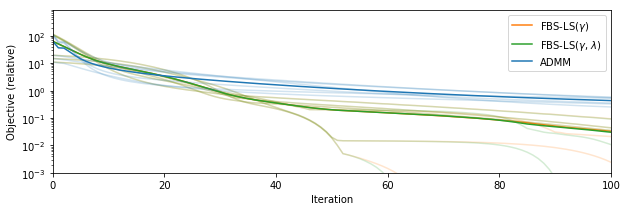

In [782]:
f = plt.figure(figsize=(10,3))
ax = plt.subplot(111)
# ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

colors = ("C%d"%x for x in [1,2,0])

for k in sorted(results_smooth.keys())[::-1]: #, key=lambda x: 0 if 'admm' in x else (1 if 'gamma' in x else 2)):
    v = results_smooth[k]
#     if 'gamma' in k:
#         continue
#     gg_mean, gg_std = plotting(v[2:], mm[2:])
#     plt.errorbar(range(gg_mean.size), gg_mean, yerr=gg_std, errorevery=2, lolims=1, label=mapping(k))
#     sns.tsplot(data=plotting(v[results_square['fbs-gamma l1'].min(axis=1) < 0 ],
#                              mm[results_square['fbs-gamma l1'].min(axis=1) < 0 ], seaborn=True), ci=100, ax=ax, color=next(colors), err_style="unit_traces",
#               legend=True, condition=mapping(k))
    sns.tsplot(data=plotting(v, mm, seaborn=True), ci=100, ax=ax, color=next(colors), err_style="unit_traces",
              legend=True, condition=mapping(k))
    
plt.xlabel("Iteration")
plt.ylabel("Objective (relative)");
plt.xlim([0, 100])
plt.ylim([1e-3, None])
plt.legend(loc='upper right');

In [784]:
f.savefig("convergence_100_smooth_0306_d.pdf", dpi=600, bbox_inches='tight')

In [511]:
from regain.forward_backward import time_graph_lasso_laplacian; reload(time_graph_lasso_laplacian)

<module 'regain.forward_backward.time_graph_lasso_laplacian' from '/home/fede/src/slipguru/regain/regain/forward_backward/time_graph_lasso_laplacian.pyc'>

In [619]:
minimums = {(alpha, beta): mm[i][0] for i, (alpha, beta) in enumerate(params_square)}

In [620]:
minimums

{(0.1, 0.1): -2192673.154871444,
 (0.1, 5): -2192668.35845531,
 (0.5, 0.1): -2192673.154871444,
 (0.5, 5): -2192668.3584553106,
 (1, 0.1): -2192673.154871444,
 (1, 5): -2192668.358455311}

In [621]:
max_iter = 50000
precisions = [1e-1, 1e-2, 1e-3]
# precisions = [1e-3]

methods = sorted(mdls.keys())
precisions = sorted(precisions)
scores = sorted(['t mean', 't std', 'iter'])

rows = methods
cols = pd.MultiIndex.from_product([precisions, scores], names=('precisions', 'score'))

dff = pd.DataFrame(columns=cols, index=rows)
idx = pd.IndexSlice

In [622]:
max_iter = 5000
for precisione, k in product(precisions, mdls):
    tt, ii = [], []
#     if not 'admm' in k or precisione!=1e-2:
#         continue
    for alpha, beta in params_square:
        print(alpha, beta, k, precisione)
        tic = time.time()
        mdls[k].set_params(alpha=alpha, beta=beta, max_iter=max_iter,
                           stop_at=minimums[(alpha, beta)],
                           stop_when=precisione).fit(X)
        toc = time.time()
        tt.append(toc-tic)
        ii.append(mdls[k].n_iter_)
        print ii
        
#         break

    res = {
        't mean': np.mean(tt),
        't std': np.std(tt),
        'iter': "%d (%d)" % (np.mean(ii), np.std(ii))
    }
    
    dff.loc[k, idx[precisione, :]] = [res[x] for x in scores]

(0.1, 0.1, 'fbs-gamma l1', 0.001)
[26]
(0.1, 5, 'fbs-gamma l1', 0.001)
[26, 29]
(0.5, 0.1, 'fbs-gamma l1', 0.001)
[26, 29, 26]
(0.5, 5, 'fbs-gamma l1', 0.001)
[26, 29, 26, 27]
(1, 0.1, 'fbs-gamma l1', 0.001)
[26, 29, 26, 27, 26]
(1, 5, 'fbs-gamma l1', 0.001)
[26, 29, 26, 27, 26, 26]
(0.1, 0.1, 'fbs-both l1', 0.001)
[26]
(0.1, 5, 'fbs-both l1', 0.001)
[26, 29]
(0.5, 0.1, 'fbs-both l1', 0.001)
[26, 29, 26]
(0.5, 5, 'fbs-both l1', 0.001)
[26, 29, 26, 27]
(1, 0.1, 'fbs-both l1', 0.001)
[26, 29, 26, 27, 26]
(1, 5, 'fbs-both l1', 0.001)
[26, 29, 26, 27, 26, 26]
(0.1, 0.1, 'admm l1', 0.001)
[5000]
(0.1, 5, 'admm l1', 0.001)
[5000, 5000]
(0.5, 0.1, 'admm l1', 0.001)
[5000, 5000, 5000]
(0.5, 5, 'admm l1', 0.001)
[5000, 5000, 5000, 5000]
(1, 0.1, 'admm l1', 0.001)
[5000, 5000, 5000, 5000, 5000]
(1, 5, 'admm l1', 0.001)
[5000, 5000, 5000, 5000, 5000, 877]
(0.1, 0.1, 'fbs-gamma l1', 0.01)
[24]
(0.1, 5, 'fbs-gamma l1', 0.01)
[24, 27]
(0.5, 0.1, 'fbs-gamma l1', 0.01)
[24, 27, 24]
(0.5, 5, 'fbs-gamma

In [624]:
dff

precisions          0.001                           0.010                     \
score                iter   t mean     t std         iter   t mean     t std   
admm l1       4312 (1536)  301.571   107.383  2623 (1757)  184.338   122.323   
fbs-both l1        26 (1)  5.58449  0.503221       24 (1)   5.4117  0.457091   
fbs-gamma l1       26 (1)  5.02327  0.334219       24 (1)     5.12  0.366391   

precisions         0.100                     
score               iter   t mean     t std  
admm l1       1060 (553)  75.2438   39.7505  
fbs-both l1       22 (1)  4.57037  0.693453  
fbs-gamma l1      22 (1)  4.79651  0.672045

In [626]:
for k in mdls:
    print mse_error(comp_cov=mdls[k].precision_)

29.047723390750008
29.047723390750008
29.047723390750008


In [586]:
dff

precisions       0.001                         0.010                      \
score             iter   t mean      t std      iter   t mean      t std   
admm l1       2000 (0)   139.38  0.0721087  2000 (0)  139.387  0.0963031   
fbs-both l1     26 (0)  33.3202     2.0701    24 (0)  29.4436    2.55309   
fbs-gamma l1    26 (0)   35.896    1.67139    24 (0)  31.5906    3.40049   

precisions       0.100                     
score             iter   t mean     t std  
admm l1       637 (41)  44.9807   2.86207  
fbs-both l1     22 (0)   30.266  0.921683  
fbs-gamma l1    22 (0)   28.847   1.19278

In [585]:
dff.loc[:, idx[[0.01], 't mean']] 

precisions,0.01
score,t mean
admm l1,139.387
fbs-both l1,29.4436
fbs-gamma l1,31.5906


In [627]:
dff_square = dff

In [628]:
%store dff_square

Stored 'dff_square' (DataFrame)


In [630]:
dff.to_latex("results_0306_l1_a.tex", float_format=lambda x: '%.3f'%x, escape=False)

In [ ]:
f.savefig("objective_square_errorbar_log.pdf", dpi=600, bbox_inches='tight')

In [ ]:
# thetaSet, empCovSet, status, gvx_smooth = TVGL.TVGL(
#     np.vstack(X.transpose(2,0,1)), X.shape[0],
#     lamb=alpha, beta=beta, indexOfPenalty=2, verbose=False, epsAbs=1e-5)
thetaSet, empCovSet, status, gvx_square = TVGL.TVGL(
    np.vstack(X.transpose(2,0,1)), X.shape[0],
    lamb=.3, beta=1.2, indexOfPenalty=1, verbose=False, epsAbs=1e-5)

In [ ]:
f = plt.figure(figsize=(10,3))
plt.title("Convergence with %s evolution" % evolution)
# plt.semilogy([x.rnorm for x in tglfb_smooth.history_], label='TGL-FB $\ell_{21}$')
plt.semilogy([x.rnorm for x in tglfb_square.history_], label='TGL-FB $\ell_1$')
# plt.semilogy([x.snorm for x in tglfb_admm_smooth.history_], label='TGL-ADMM $\ell_2^2$')
plt.semilogy([(x.snorm/tglfb_admm_square.rho)**2/3 for x in tglfb_admm_square.history_], label='TGL-ADMM $\ell_1$')
plt.semilogy([x/3 for x in gvx_square.history_], label='TVGL $\ell_1$')
# plt.semilogy([x for x in gvx_smooth.history_], label='TVGL $\ell_{21}$')
plt.legend()
plt.ylim([1e-10, 100]);
plt.xlim([0, 50]);

plt.xlabel("Iteration")
plt.ylabel("Difference between iterates");

In [ ]:
score = 'f1'
f = plt.figure(figsize=(10,3))
plt.title(r"$F_1$-score with %s evolution" % (evolution))
# plt.semilogy([x.rnorm for x in tglfb_smooth.history_], label='TGL-FB $\ell_{21}$')
plt.plot([error_function(x.precision)[score]
              for x in tglfb_square.history_], label='TGL-FB $\ell_1$')
# plt.semilogy([x.snorm for x in tglfb_admm_smooth.history_], label='TGL-ADMM $\ell_2^2$')
plt.plot([error_function(x.precision)[score]
              for x in tglfb_admm_square.history_], label='TGL-ADMM $\ell_1$')
# plt.semilogy([error_function(x.precision)[score]
#                for x in gvx_square.history_], label='TVGL $\ell_1$')
# plt.semilogy([x for x in gvx_smooth.history_], label='TVGL $\ell_{21}$')
plt.legend()
# plt.ylim([1e-10, 100]);
# plt.ylim([0, 1])
plt.xlim([0, 50]);

plt.ylabel(r"$F_1$-score")
plt.xlabel("Iteration")

In [ ]:
evolution = 'smooth'; alpha = 0.53; beta = 5
X = data[evolution].data

tglfb_square2 = time_graph_lasso_.TimeGraphLassoForwardBackward(
    verbose=2, gamma=1, alpha=alpha, beta=beta,
    delta=1e-8, choose='lamda', lamda_criterion='c',
    lamda=1, tol=1e-5, eps=0.9, return_history=True,
    time_norm=1, max_iter=300, time_on_axis='last').fit(X)

tglfb_smooth2 = time_graph_lasso_.TimeGraphLassoForwardBackward(
    verbose=2, gamma=1, alpha=alpha, beta=beta,
    delta=1e-8, choose='lamda', lamda_criterion='c',
    lamda=1, tol=1e-5, eps=0.9, return_history=True,
    time_norm=2, max_iter=300, time_on_axis='last').fit(X)

thetaSet, empCovSet, status, gvx_square2 = TVGL.TVGL(
    np.vstack(X.transpose(2,0,1)), X.shape[0],
    lamb=alpha, beta=beta, indexOfPenalty=2, verbose=False, epsAbs=1e-5)
thetaSet, empCovSet, status, gvx_smooth2 = TVGL.TVGL(
    np.vstack(X.transpose(2,0,1)), X.shape[0],
    lamb=alpha, beta=beta, indexOfPenalty=1, verbose=False, epsAbs=1e-5)

In [ ]:
f = plt.figure()
plt.title("Evolution: %s" % evolution)
plt.semilogy([x.rnorm for x in tglfb_smooth2.history_], label='TVGL $\ell_{21}$')
plt.semilogy([x.rnorm for x in tglfb_square2.history_], label='TGL-FB $\ell_1$')
plt.semilogy([x for x in gvx_square2.history_], label='TVGL $\ell_1$')
plt.semilogy([x for x in gvx_smooth2.history_], label='TVGL $\ell_{21}$')
plt.legend()
plt.ylim([0.01,None]);

In [ ]:
error_function = partial(utils.structure_error, data[evolution].thetas,
                             no_diagonal=0, thresholding=1, eps=1e-4)

res = error_function(tglfb.precision_)
res

### BayesOptimisation
Since we have lots of hyper-parameters, we rely on a Bayesian optimisation procedure in order to select the best hyper-parameters, treating the scoring function of our algorithm as a black-box for the gaussian process underlying the Bayesian optimisation.

Such procedure is performed via the `scikit-optimize` package.

In [631]:
from skopt import searchcv

X = data['smooth'].data

domain = {'alpha': Real(1e-2, 1, prior='uniform'),
          'beta': Real(1e-3, 1e-1, prior='uniform'),
#           'time_norm': Categorical([1, 2])
         }

mdl = time_graph_lasso_laplacian.TimeGraphLassoForwardBackward(
    verbose=0, gamma=.2, delta=delta, choose='gamma',
    lamda=1, tol=1e-4, eps=0.9, debug=1, vareps=0, max_iter=100, time_on_axis='last')
    
cv = ShuffleSplit(2, test_size=0.3)
    
bscv = searchcv.BayesSearchCV(
    mdl, domain, n_iter=50, cv=cv, verbose=0, n_jobs=1, iid=True, n_points=5,
    error_score=-np.inf)

def on_step(optim_result):
    score = bscv.best_score_
    print("best score: %s" % score)

bscv.fit(X, callback=on_step)

best score: 100320.53104195614
best score: 103277.8272127945
best score: 105330.4107068051
best score: 105330.4107068051
best score: 105330.4107068051
best score: 105330.4107068051
best score: 106288.09449395214
best score: 106288.09449395214
best score: 106288.09449395214
best score: 106288.09449395214


BayesSearchCV(cv=ShuffleSplit(n_splits=2, random_state=None, test_size=0.3, train_size=None),
       error_score=-inf,
       estimator=TimeGraphLassoForwardBackward(alpha=0.01, assume_centered=False, beta=1.0,
               choose='gamma', compute_objective=True, debug=1, delta=0.9,
               eps=0.9, gamma=0.2, lamda=1, lamda_criterion='b',
               max_iter=100, return_history=False,
               return_n_linesearch=False, stop_at=None, stop_when=0.0001,
               time_norm=1, time_on_axis='last', tol=0.0001, vareps=0,
               verbose=0),
       fit_params=None, iid=True, n_iter=50, n_jobs=1, n_points=5,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
       refit=True, return_train_score=False, scoring=None,
       search_spaces={'alpha': Real(low=0.01, high=1, prior='uniform', transform='identity'), 'beta': Real(low=0.001, high=0.1, prior='uniform', transform='identity')},
       verbose=0)

In [632]:
bscv.best_params_

{'alpha': 0.7890546745267578, 'beta': 0.020163185985406864}

In [738]:
from skopt import searchcv

X = data['square'].data

domain = {'alpha': Real(1e-2, 1, prior='uniform'),
          'beta': Real(0.1, 5, prior='uniform'),
         }

mdl_square = time_graph_lasso_.TimeGraphLassoForwardBackward(
        verbose=0, gamma=1, delta=delta, choose='gamma',
        lamda=1, tol=1e-4, eps=eps, debug=1, vareps=0,
        time_norm=1, max_iter=50, time_on_axis='last')
    
cv = ShuffleSplit(2, test_size=0.3)
    
bscv_square2 = searchcv.BayesSearchCV(
    mdl_square, domain, n_iter=50, cv=cv, verbose=0, n_jobs=1, iid=True, n_points=5,
    error_score=-np.inf)

def on_step(optim_result):
    score = bscv_square2.best_score_
    print("best score: %s" % score)

bscv_square2.fit(X, callback=on_step)

best score: -455065.4067739221
best score: -446403.81738803687
best score: -436921.1515404107
best score: -430382.2188747936
best score: -430382.2188747936
best score: -430382.2188747936
best score: -426486.2715626585
best score: -426486.2715626585
best score: -426486.2715626585
best score: -426486.2715626585


BayesSearchCV(cv=ShuffleSplit(n_splits=2, random_state=None, test_size=0.3, train_size=None),
       error_score=-inf,
       estimator=TimeGraphLassoForwardBackward(alpha=0.01, assume_centered=False, beta=1.0,
               choose='gamma', compute_objective=True, debug=1, delta=0.9,
               eps=0.7, gamma=1, lamda=1, lamda_criterion='b', max_iter=50,
               return_history=False, return_n_linesearch=False,
               stop_at=None, stop_when=0.0001, time_norm=1,
               time_on_axis='last', tol=0.0001, vareps=0, verbose=0),
       fit_params=None, iid=True, n_iter=50, n_jobs=1, n_points=5,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
       refit=True, return_train_score=False, scoring=None,
       search_spaces={'alpha': Real(low=0.01, high=1, prior='uniform', transform='identity'), 'beta': Real(low=0.1, high=5, prior='uniform', transform='identity')},
       verbose=0)

In [708]:
bscv_square2.best_params_

{'alpha': 0.8235256537766323, 'beta': 2.054205049247515}

In [764]:
reload(utils)
mse_error = partial(utils.error_norm, data['smooth'].thetas, upper_triangular=True, n=True)
print mse_error(comp_cov=bscv.best_estimator_.precision_)

mse_error = partial(utils.error_norm, data['square'].thetas, upper_triangular=True, n=True)
print mse_error(comp_cov=bscv_square.best_estimator_.precision_)

4.9774021691171e-05
6.648342281800178e-05


In [768]:
bscv_square.best_estimator_.score(data['square'].data)

728758.7659457853

In [769]:
bscv.best_estimator_.score(data['smooth'].data)

358016.5352491819

In [723]:
mmm = time_graph_lasso_.TimeGraphLassoForwardBackward(
        verbose=0, gamma=1, delta=delta, choose='both',
        lamda=1, tol=1e-4, eps=eps, debug=1, vareps=200, alpha=30, beta=10,
        time_norm=1, max_iter=450, time_on_axis='last').fit(data['square'].data)

In [724]:
print mse_error(comp_cov=mmm.precision_)

29.047723390750008


### GridSearchCV
As for the hyper-parameters tuning, one may choose to fix a grid of parameters and select the best ones.
For this we can use `GridSearchCV`, from the `scikit-learn` library.

In [ ]:
param_grid=dict(alpha=np.logspace(-2,0,3), beta=np.logspace(-2,0,3),
                time_norm=[1, 2])

mdl = time_graph_lasso_.TimeGraphLassoForwardBackward(
    verbose=0, time_on_axis='last')
    
cv = ShuffleSplit(2, test_size=0.2)
ltgl = GridSearchCV(mdl, param_grid, cv=cv, verbose=1)
ltgl.fit(data_grid)

## Memory requirements

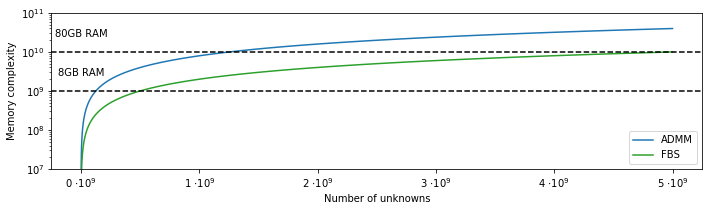

In [785]:
def memory_requirements(n_dim, n_times, alg='admm'):
    m = n_dim ** 2 * n_times * 2  # theta + emp_cov
    
    if alg == 'admm':
        m += n_dim ** 2 * n_times * 2 # Z0, U0
        m += n_dim ** 2 * (n_times - 1) * 4 # Z1, U1, Z2, U2
    return m / 2.


from matplotlib.ticker import FuncFormatter
def millions(x, pos):
    return '%1.0f $\cdot 10^9$' % (x*1e-9)

formatter = FuncFormatter(millions)

f, ax = plt.subplots(figsize=(10,3))
ax.xaxis.set_major_formatter(formatter)

# ax.set_xscale("log", nonposx='clip')
# ax.set_yscale("log", nonposy='clip')

T = 100
n_dims = np.linspace(100, 1e4, 100)
unknowns = n_dims * (n_dims - 1) / 2. * T

plt.semilogy(unknowns, [memory_requirements(n_dim=dim, n_times=T, alg='admm') for dim in n_dims], label='ADMM')
plt.semilogy(unknowns, [memory_requirements(n_dim=dim, n_times=T, alg='fbs') for dim in n_dims], label='FBS', c="C2")

plt.axhline(1e9, ls='--', c='k')
# plt.axhline(1e10, label="80GB")
plt.axhline(1e10, ls='--', c='k')

plt.text(45000, 1e9*4, '8GB RAM',
         verticalalignment='top',
         horizontalalignment='center')

plt.text(5000, 1e10*4, '80GB RAM',
         verticalalignment='top',
         horizontalalignment='center')

plt.ylabel("Memory complexity")
plt.xlabel("Number of unknowns")

plt.legend(loc=4);
plt.tight_layout()
plt.ylim([1e7, 1e11])

f.savefig("ram_requirements.pdf", dpi=600, bbox_inches='tight')